In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth=GoogleAuth()
gauth.credentials=GoogleCredentials.get_application_default()
drive=GoogleDrive(gauth)

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Conv2D , MaxPooling2D,Dense,Flatten,Embedding
from keras.layers.core import Dense,Dropout,Activation
from keras.engine import InputLayer
from keras import activations
from keras.metrics import top_k_categorical_accuracy
import pickle
from keras import optimizers
import tensorflow as tf
import keras.backend as K

def f_1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [0]:
train_downloaded=drive.CreateFile({"id":"1sfrMCioGrEXx92GF35ShYmq1w-vj7YQE"})
train_downloaded.GetContentFile("ana.csv")


In [0]:
import pandas as pd
df=pd.read_csv('ana.csv')
c=[]
f=0
d=list(set(df.category.values))
for i in range(len(d)):
    for j in range(len(df.category.values)):
        if d[i]==df.category.values[j]:
            f=f+1
    c.append([f,d[i]])
    f=0
c=pd.DataFrame(c)
c=c.rename(index=str,columns={0:'count',1:'item'})
c

,count,item
0,2120,1
1,1167,2
2,916,3
3,832,4
4,1217,5


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5')]

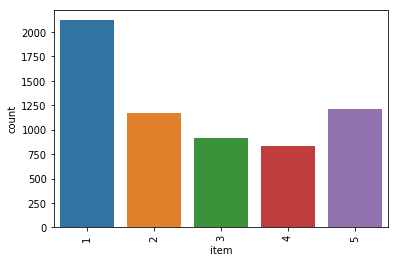

In [0]:
a=sns.barplot(x='item',y='count',data=c)
a.set_xticklabels(a.get_xticklabels(),rotation=90)

In [0]:

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df.category.values),
                                                 df.category.values)

In [0]:
d=[]
for i in range(len(c.item.values)):
    d.append([c.item.values[i],class_weights[i]])

In [0]:
df1=pd.DataFrame(d)

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5')]

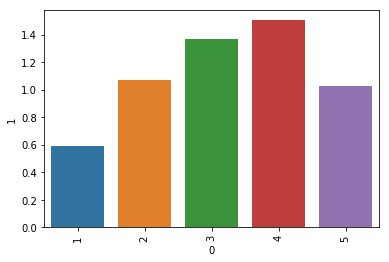

In [0]:
g=sns.barplot(x=0,y=1,data=df1)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

In [0]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.listdir('drive/My Drive/images2')

['1', '5', '4', '3', '2']

In [0]:
data_generator = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range = 0.4,
                                   height_shift_range = 0.4,
                                   zoom_range=0.3,
                                   rotation_range=20,
                                   )
batch_size = 32
train_generator = data_generator.flow_from_directory(
        'drive/My Drive/images2',
        target_size=(224,224),
        batch_size=batch_size,
        class_mode='categorical')

num_classes = len(train_generator.class_indices)

Found 6252 images belonging to 5 classes.


In [0]:
from keras.applications import VGG16
image_size, image_size=224,224
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))


In [0]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer)

In [0]:
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

In [0]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [0]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [0]:
train_batchsize = 100
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        'drive/My Drive/images2',
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
 
# Save the model
model.save('small_last4.h5')
earlyStopping = EarlyStopping(monitor='val_loss', patience=20
                              , verbose=0,
                                  mode='min')
ckpt = ModelCheckpoint('.model.hdf5', save_best_only=True,
                           monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                       patience=7, verbose=1, epsilon=1e-4,
                                       mode='min')
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f_1])
model.summary()
history=model.fit_generator(train_generator,steps_per_epoch=62,epochs=50,class_weight=[0.58981132, 1.0714653 , 1.3650655 , 1.50288462, 1.02744454],callbacks=[earlyStopping, ckpt, reduce_lr_loss])
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['f_1'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# create on Colab directory
model.save('model.h5')    
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()

In [0]:
from keras.models import load_model 
model=load_model('drive/My Drive/model1.h5')

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'drive/My Drive/class',
        target_size=(224, 224),
        color_mode="rgb",
        shuffle = False,
    class_mode=None,
        batch_size=32)

filenames = test_generator.filenames
nb_samples = len(filenames)
print(nb_samples)

Found 2680 images belonging to 1 classes.
2680


In [0]:
test_generator.reset()
predict = model.predict_generator(test_generator,verbose=1,steps = 2680/32)

84/83 [==============================] - 13s 157ms/step


In [0]:
predicted_class_indices=np.argmax(predict,axis=1)

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [0]:
filenames=test_generator.filenames
results=pd.DataFrame({"images":filenames,
                      "Predictions":predictions})

In [0]:
df=result
for  i in range(len(df.values)):
  df.images.values[i]=df.images.values[i].split('/')[1] 

In [0]:
df1 = df
df1.to_csv('estimate.csv',index=False)
!cp estimate.csv drive/My\ Drive/

'images,Predictions\n1007700.jpg,4\n1011369.jpg,4\n1051155.jpg,4\n1062001.jpg,2\n1069397.jpg,4\n1072861.jpg,4\n1097264.jpg,4\n1098763.jpg,2\n1098766.jpg,2\n1101145.jpg,4\n1114371.jpg,4\n1114781.jpg,4\n1115492.jpg,4\n1121306.jpg,4\n1123736.jpg,2\n1124946.jpg,2\n1125700.jpg,4\n1127236.jpg,2\n1127336.jpg,2\n1130300.jpg,4\n1131990.jpg,2\n1141996.jpg,4\n1145082.jpg,2\n1153400.jpg,4\n1162763.jpg,4\n1162764.jpg,4\n1162765.jpg,4\n1163874.jpg,4\n1174623.jpg,4\n1185778.jpg,4\n1186207.jpg,4\n1193420.jpg,4\n1203926.jpg,2\n1228622.jpg,4\n1229806.jpg,4\n1243717.jpg,4\n1244690.jpg,4\n1244768.jpg,4\n1250078.jpg,4\n1250085.jpg,4\n1252407.jpg,4\n1260394.jpg,4\n1263061.jpg,4\n1263459.jpg,4\n1289223.jpg,2\n1289225.jpg,2\n1296498.jpg,4\n1311396.jpg,4\n1314965.jpg,4\n1324036.jpg,4\n1334848.jpg,2\n1334855.jpg,2\n1342277.jpg,4\n1345016.jpg,4\n1352852.jpg,4\n1359851.jpg,4\n1368439.jpg,4\n1382476.jpg,4\n1386041.jpg,2\n1396598.jpg,4\n1400085.jpg,4\n1400092.jpg,4\n1412936.jpg,4\n1414715.jpg,4\n1414770.jpg,4\n1416